# [Grupo Bimbo Inventory Demand](https://www.kaggle.com/c/grupo-bimbo-inventory-demand)

#### CDIPS Data Science Workshop

Team    : Tom Angsten, Saurabh Bajaj and Hieu H. Pham

Mentors : Andrea Pasqua and Aboubakeur Namous (Radius)

>In this competition, you will forecast the demand of a product for a given week, at a particular store. The dataset you are given consists of 9 weeks of sales transactions in Mexico. Every week, there are delivery trucks that deliver products to the vendors. Each transaction consists of sales and returns. Returns are the products that are unsold and expired. The demand for a product in a certain week is defined as the sales this week subtracted by the return next week.

>The train and test dataset are split based on time, as well as the public and private leaderboard dataset split.

#### Things to note
* There may be products in the test set that don't exist in the train set. This is the expected behavior of inventory data, since there are new products being sold all the time. Your model should be able to accommodate this.
* There are duplicate Cliente_ID's in cliente_tabla, which means one Cliente_ID may have multiple NombreCliente that are very similar. This is due to the NombreCliente being noisy and not standardized in the raw data, so it is up to you to decide how to clean up and use this information. 
* The adjusted demand (Demanda_uni_equil) is always >= 0 since demand should be either 0 or a positive value. The reason that Venta_uni_hoy - Dev_uni_proxima sometimes has negative values is that the returns records sometimes carry over a few weeks.

#### Fields Descriptions
+ train.csv — the training set (74180464, 11)
+ test.csv — the test set (6999251, 7)
+ sample_submission.csv — a sample submission file in the correct format
+ cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
+ producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
+ town_state.csv — town and state (can be joined with train/test on Agencia_ID)

#### Data Fields
* Semana — Week number (From Thursday to Wednesday)
* Agencia_ID — Sales Depot ID
* Canal_ID — Sales Channel ID
* Ruta_SAK — Route ID (Several routes = Sales Depot)
* Cliente_ID — Client ID
* NombreCliente — Client name
* Producto_ID — Product ID
* NombreProducto — Product Name
* Venta_uni_hoy — Sales unit this week (integer)
* Venta_hoy — Sales this week (unit: pesos)
* Dev_uni_proxima — Returns unit next week (integer)
* Dev_proxima — Returns next week (unit: pesos)
* Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)

In [16]:
ls data/

cliente_tabla.csv*      test.csv*               train.csv*
producto_tabla.csv*     test_merge.csv          train_merge.csv
sample_submission.csv*  town_state.csv          train_merge_weight.csv


In [1]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

#### Reading data sets:

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
cliente_tabla = pd.read_csv('data/cliente_tabla.csv')
town_state = pd.read_csv('data/town_state.csv')
producto_tabla = pd.read_csv('data/producto_tabla.csv')

In [22]:
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [23]:
test.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238
2,2,10,2045,1,2831,4549769,32940
3,3,11,1227,1,4448,4717855,43066
4,4,11,1219,1,1130,966351,1277


In [24]:
test.shape

(6999251, 7)

In [19]:
print(train.shape)
train

(74180464, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.00,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.00,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.00,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.00,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.00,3
5,3,1110,7,3301,15766,1250,5,38.20,0,0.00,5
6,3,1110,7,3301,15766,1309,3,20.28,0,0.00,3
7,3,1110,7,3301,15766,3894,6,56.10,0,0.00,6
8,3,1110,7,3301,15766,4085,4,24.60,0,0.00,4
9,3,1110,7,3301,15766,5310,6,31.68,0,0.00,6


In [20]:
test = train[train.Dev_uni_proxima > train.Venta_uni_hoy]

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
91,3,1110,7,3301,198780,1187,0,0.00,2,297.00,0
230,3,1110,7,3301,1307034,739,0,0.00,2,166.00,0
385,3,1110,7,3301,2336454,1187,0,0.00,1,148.50,0
594,3,1110,7,3302,319684,30571,3,18.75,150,937.50,0
715,3,1110,7,3302,1614050,4245,0,0.00,1,10.48,0
1262,3,1110,7,3304,384195,1125,16,153.60,20,192.00,0
1275,3,1110,7,3304,817296,1250,2,15.28,26,198.64,0
1276,3,1110,7,3304,817296,2233,1,19.94,10,199.40,0
1277,3,1110,7,3304,817296,32802,4,47.64,12,142.92,0
1282,3,1110,7,3304,838989,32802,2,23.82,12,142.92,0


Number of values for each column in the train data set

In [21]:
len(test)

6999251

In [34]:
print ('In train.csv, there are: ')
for col in train.columns:
     print ('{:>10}{:>20}'.format(len(train[col].value_counts()), col))

In train.csv, there are: 
         7              Semana
       552          Agencia_ID
         9            Canal_ID
      3603            Ruta_SAK
    880604          Cliente_ID
      1799         Producto_ID
      2116       Venta_uni_hoy
     78140           Venta_hoy
       558     Dev_uni_proxima
     14707         Dev_proxima
      2091   Demanda_uni_equil


### Question:
      Canal > Agencia > Rute > Cliente ????

3    11165207
4    11009593
5    10615397
9    10408713
8    10406868
7    10382849
6    10191837
Name: Semana, dtype: int64


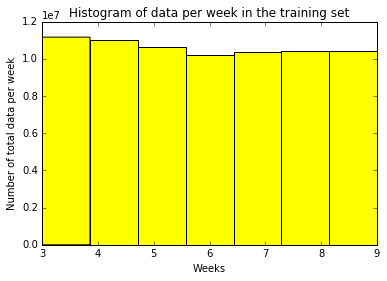

In [11]:
print(train.Semana.value_counts())
plt.hist(train.Semana, bins = 7, color='yellow')
plt.xlabel('Weeks')
plt.ylabel('Number of total data per week')
plt.title ('Histogram of data per week in the training set')
plt.show()

1     67435217
4      3757773
11      982295
2       839496
7       671128
6       281389
5       145818
8        66970
9          378
Name: Canal_ID, dtype: int64


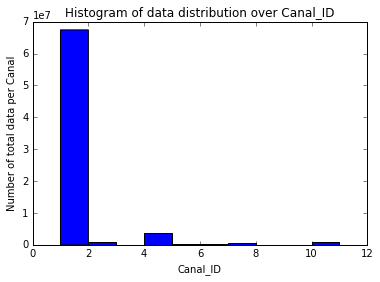

In [12]:
print(train.Canal_ID.value_counts())
plt.hist(train.Canal_ID, bins = 10, facecolor='b')
plt.xlabel('Canal_ID')
plt.ylabel('Number of total data per Canal')
plt.title ('Histogram of data distribution over Canal_ID')
plt.show()

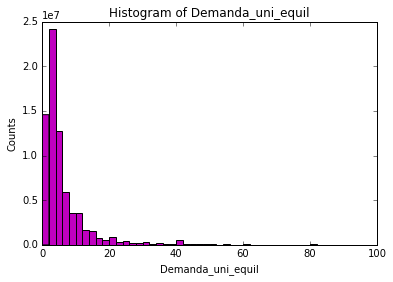

In [14]:
plt.hist(train.Demanda_uni_equil, bins = 50, color='m', range=(0, 100))
plt.xlabel('Demanda_uni_equil')
plt.ylabel('Counts')
plt.title ('Histogram of Demanda_uni_equil')
plt.show()

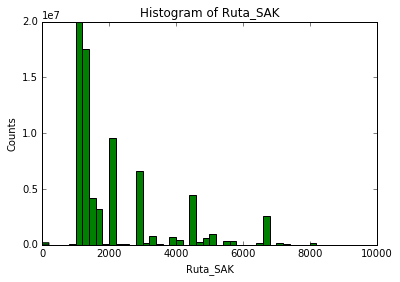

In [56]:
plt.hist(train.Ruta_SAK, bins = 50, color='g')
plt.xlabel('Ruta_SAK')
plt.ylabel('Counts')
plt.title ('Histogram of Ruta_SAK')
plt.show()

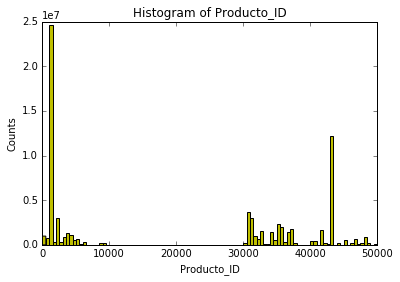

In [25]:
plt.hist(train.Producto_ID, bins = 100, color='y')
plt.xlabel('Producto_ID')
plt.ylabel('Counts')
plt.title ('Histogram of Producto_ID')
plt.show()

#### Cheking the Cliente_ID, Producto_ID and Agencia_ID

In [26]:
print(cliente_tabla.shape)
print ('There is', cliente_tabla.duplicated(['Cliente_ID']).sum(),'duplicated Cliente_ID in cliente_tabla.csv' )
cliente_tabla.head()

(930500, 2)
There is 0 duplicated Cliente_ID in cliente_tabla.csv


,Cliente_ID,NombreCliente
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE
3,3,EL MORENO
4,4,SDN SER DE ALIM CUERPO SA CIA DE INT


Therefore need to drop duplicate Cliente_ID and associated names

In [57]:
cliente_tabla = cliente_tabla.drop_duplicates(['Cliente_ID'], keep = 'first')
print(cliente_tabla.shape)

(930500, 2)


In [35]:
print(producto_tabla.shape)
print ('There is', producto_tabla.duplicated(['Producto_ID']).sum(),'duplicated Producto_ID' )
producto_tabla.head(2)

(2592, 2)
There is 0 duplicated Producto_ID


,Producto_ID,NombreProducto
0,0,NO IDENTIFICADO 0
1,9,Capuccino Moka 750g NES 9


In [6]:
print(town_state.shape)
print ('There is', town_state.duplicated(['Agencia_ID']).sum(),'duplicated Agencia_ID' )
print ('There are',len(town_state.Town.value_counts()), 'towns' )
print ('      and',len(town_state.State.value_counts()), 'states in town_state.csv' )
town_state.head(2)

(790, 3)
There is 0 duplicated Agencia_ID
There are 260 towns
      and 33 states in town_state.csv


,Agencia_ID,Town,State
0,1110,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,1111,2002 AG. AZCAPOTZALCO,"MÉXICO, D.F."


#### Data merging for the training set

In [ ]:
cliente_tabla = cliente_tabla.drop_duplicates(['Cliente_ID'], keep = 'first')
train_tmp = train.merge(cliente_tabla, on = 'Cliente_ID')

In [ ]:
train_tmp = train_tmp.merge(producto_tabla, on = 'Producto_ID')

In [ ]:
train_tmp = train_tmp.merge(town_state, on ='Agencia_ID')

In [ ]:
#train_tmp.to_csv('data/train_merge.csv')

In [7]:
train_merge = pd.read_csv('data/train_merge.csv', index_col=0)

#### Cheking the train_merge set

In [8]:
print ('In train_merge.csv, there are: ')
for col in train_merge.columns:
     print ('{:>10}{:>20}'.format(len(train_merge[col].value_counts()), col))

print ('\nIn train.csv, there are: ')
for col in train.columns:
     print ('{:>10}{:>20}'.format(len(train[col].value_counts()), col))

In train_merge.csv, there are: 
         7              Semana
       552          Agencia_ID
         9            Canal_ID
      3603            Ruta_SAK
    880604          Cliente_ID
      1799         Producto_ID
      2116       Venta_uni_hoy
     78140           Venta_hoy
       558     Dev_uni_proxima
     14707         Dev_proxima
      2091   Demanda_uni_equil
    299285       NombreCliente
      1799      NombreProducto
       257                Town
        33               State

In train.csv, there are: 
         7              Semana
       552          Agencia_ID
         9            Canal_ID
      3603            Ruta_SAK
    880604          Cliente_ID
      1799         Producto_ID
      2116       Venta_uni_hoy
     78140           Venta_hoy
       558     Dev_uni_proxima
     14707         Dev_proxima
      2091   Demanda_uni_equil


In [8]:
train_merge.head(3)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreCliente,NombreProducto,Town,State
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,2008 AG. LAGO FILT,"MÉXICO, D.F."
1,4,1110,7,3301,15766,1212,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,2008 AG. LAGO FILT,"MÉXICO, D.F."
2,5,1110,7,3301,15766,1212,5,41.90,0,0.0,5,PUESTO DE PERIODICOS LAZARO,Roles Canela 2p 120g BIM 1212,2008 AG. LAGO FILT,"MÉXICO, D.F."


In [12]:
train_merge.describe()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
count,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07
mean,5.950021e+00,2.536509e+03,1.383181e+00,2.114855e+03,1.802119e+06,2.084081e+04,7.310163e+00,6.854452e+01,1.302577e-01,1.243248e+00,7.224564e+00
std,2.013175e+00,4.075124e+03,1.463266e+00,1.487744e+03,2.349577e+06,1.866392e+04,2.196734e+01,3.389795e+02,2.932320e+01,3.921552e+01,2.177119e+01
min,3.000000e+00,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.312000e+03,1.000000e+00,1.161000e+03,3.567670e+05,1.242000e+03,2.000000e+00,1.676000e+01,0.000000e+00,0.000000e+00,2.000000e+00
50%,6.000000e+00,1.613000e+03,1.000000e+00,1.286000e+03,1.193385e+06,3.054900e+04,3.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,3.000000e+00
75%,8.000000e+00,2.036000e+03,1.000000e+00,2.802000e+03,2.371091e+06,3.742600e+04,7.000000e+00,5.610000e+01,0.000000e+00,0.000000e+00,6.000000e+00
max,9.000000e+00,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,7.200000e+03,6.473600e+05,2.500000e+05,1.307600e+05,5.000000e+03


In [9]:
train.describe()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
count,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07,7.418046e+07
mean,5.950021e+00,2.536509e+03,1.383181e+00,2.114855e+03,1.802119e+06,2.084081e+04,7.310163e+00,6.854452e+01,1.302577e-01,1.243248e+00,7.224564e+00
std,2.013175e+00,4.075124e+03,1.463266e+00,1.487744e+03,2.349577e+06,1.866392e+04,2.196734e+01,3.389795e+02,2.932320e+01,3.921552e+01,2.177119e+01
min,3.000000e+00,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,1.312000e+03,1.000000e+00,1.161000e+03,3.567670e+05,1.242000e+03,2.000000e+00,1.676000e+01,0.000000e+00,0.000000e+00,2.000000e+00
50%,6.000000e+00,1.613000e+03,1.000000e+00,1.286000e+03,1.193385e+06,3.054900e+04,3.000000e+00,3.000000e+01,0.000000e+00,0.000000e+00,3.000000e+00
75%,8.000000e+00,2.036000e+03,1.000000e+00,2.802000e+03,2.371091e+06,3.742600e+04,7.000000e+00,5.610000e+01,0.000000e+00,0.000000e+00,6.000000e+00
max,9.000000e+00,2.575900e+04,1.100000e+01,9.991000e+03,2.015152e+09,4.999700e+04,7.200000e+03,6.473600e+05,2.500000e+05,1.307600e+05,5.000000e+03


#### Taking care of negative sale and missing data

In [10]:
zero_sale = train_merge[train_merge.Demanda_uni_equil < 0]
assert (len(zero_sale) == 0), 'there is no negative sale'

train_na = train_merge.dropna()
assert (train_na.shape == train_merge.shape), 'there is no missing data'

print('Cool, there are no negative sale and missing data from train_merge.csv!')

Cool, there are no negative sale and missing data from train_merge.csv!


#### In case needs to take into account the weight and brand of products
extract short_name, brand, weight and pieces from NombreProducto

code taken from [here](https://www.kaggle.com/vykhand/grupo-bimbo-inventory-demand/exploring-products) 

In [11]:
products  = pd.read_csv('data/producto_tabla.csv')
products['short_name'] = products.NombreProducto.str.extract('^(\D*)', expand=False)
products['brand'] = products.NombreProducto.str.extract('^.+\s(\D+) \d+$', expand=False)
w = products.NombreProducto.str.extract('(\d+)(Kg|g)', expand=True)
products['weight'] = w[0].astype('float')*w[1].map({'Kg':1000, 'g':1})
products['pieces'] =  products.NombreProducto.str.extract('(\d+)p ', expand=False).astype('float')
products.head(3)

,Producto_ID,NombreProducto,short_name,brand,weight,pieces
0,0,NO IDENTIFICADO 0,NO IDENTIFICADO,IDENTIFICADO,NaN,NaN
1,9,Capuccino Moka 750g NES 9,Capuccino Moka,NES,750.0,NaN
2,41,Bimbollos Ext sAjonjoli 6p 480g BIM 41,Bimbollos Ext sAjonjoli,BIM,480.0,6.0


In [12]:
print ('There are', len(products.weight)-len(products.weight.dropna()), ' products without weight info')
print ('         ', len(products.pieces)-len(products.pieces.dropna()), 'products without pieces info')
print ('         ', len(products.brand)-len(products.brand.dropna()), '   products without brand info')
print ('    among', len(products.pieces), 'products')

There are 109  products without weight info
          1475 products without pieces info
          1    products without brand info
    among 2592 products


In [ ]:
train_tmp2 = train_merge.merge(products, on = 'Producto_ID')

In [ ]:
train_tmp2 = train_tmp2.drop(['NombreProducto_y','NombreProducto_x'], axis =1)

In [ ]:
train_tmp2.head(3)

In [ ]:
train_tmp2.to_csv('data/train_merge_weight.csv')

Write this training set to train_merge_weight.csv

#### Cheking the train_merge_weight.csv 
(in which the weight, piece and brand info were included)

In [13]:
train_merge_two = pd.read_csv('data/train_merge_weight.csv', index_col = 0)

In [49]:
train_merge_two.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,NombreCliente,Town,State,short_name,brand,weight,pieces
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F.",Roles Canela,BIM,120.0,2.0
1,4,1110,7,3301,15766,1212,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F.",Roles Canela,BIM,120.0,2.0
2,5,1110,7,3301,15766,1212,5,41.90,0,0.0,5,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F.",Roles Canela,BIM,120.0,2.0
3,8,1110,7,3301,15766,1212,4,33.52,0,0.0,4,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F.",Roles Canela,BIM,120.0,2.0
4,9,1110,7,3301,15766,1212,1,8.38,0,0.0,1,PUESTO DE PERIODICOS LAZARO,2008 AG. LAGO FILT,"MÉXICO, D.F.",Roles Canela,BIM,120.0,2.0


In [45]:
print ('In train_merge_two.csv, there are: ')
for col in train_merge_two.columns:
     print ('{:>10}{:>20}'.format(len(train_merge_two[col].value_counts()), col))

In train_merge_two.csv, there are: 
         7              Semana
       552          Agencia_ID
         9            Canal_ID
      3603            Ruta_SAK
    880604          Cliente_ID
      1799         Producto_ID
      2116       Venta_uni_hoy
     78140           Venta_hoy
       558     Dev_uni_proxima
     14707         Dev_proxima
      2091   Demanda_uni_equil
    299285       NombreCliente
       257                Town
        33               State
       715          short_name
        30               brand
       271              weight
        34              pieces


In [14]:
print ('There are', len(train_merge_two.weight)-len(train_merge_two.weight.dropna()), '  data without weight info')
print ('         ', len(train_merge_two.pieces)-len(train_merge_two.pieces.dropna()), 'data without pieces info')
print ('         ', len(train_merge_two.brand)-len(train_merge_two.brand.dropna()), '    data without brand info')
print ('    among', len(train_merge_two.pieces), 'data')

There are 687518   data without weight info
          26141777 data without pieces info
          0     data without brand info
    among 74180464 data


In [89]:
h = train[train.Producto_ID==34226]

In [79]:
h3 = h[h.Semana==3]

In [60]:
h3.Dev_uni_proxima.value_counts()

0     188258
1       3439
2       1197
3        307
4        122
5         65
6         54
7         27
8         20
9         17
11        11
12         8
10         8
13         8
17         6
14         4
16         3
18         3
15         2
33         1
20         1
22         1
28         1
60         1
Name: Dev_uni_proxima, dtype: int64

In [86]:
train.tail()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
74180459,9,25759,1,5517,4528866,32873,4,27.76,0,0.00,4
74180460,9,25759,1,5517,4528866,34226,4,37.04,0,0.00,4
74180461,9,25759,1,5517,4528866,45112,4,51.00,0,0.00,4
74180462,9,25759,1,5517,4547943,40217,3,26.94,3,26.94,0
74180463,9,25759,1,5517,4708097,43159,1,10.40,0,0.00,1


In [90]:
h_group.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil


In [91]:
h_group = h.groupby('Semana', as_index=False).sum()

In [92]:
h_group.Semana

0    3
1    4
2    5
3    6
4    7
5    8
6    9
Name: Semana, dtype: int64

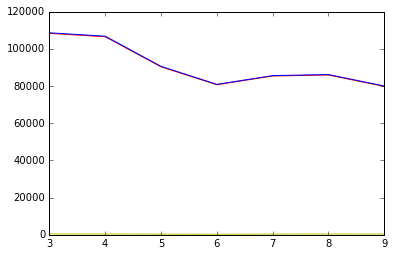

In [93]:
#plt.plot(h_group.Semana.tolist(), h_group.Demanda_uni_equil.tolist())
plt.plot(h_group.Semana.tolist(), h_group.Demanda_uni_equil.tolist(), 'r', h_group.Semana.tolist(), h_group.Venta_uni_hoy.tolist(), 'b', h_group.Semana.tolist(), h_group.Dev_uni_proxima.tolist(), 'y')

In [68]:
h_group.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,458619780,251487,312427684,355739704090,234599568,596740,5.007208e+06,9247,77781.00,589380
1,4,446933661,237189,293048150,331877015283,218328468,546823,4.577619e+06,10818,91077.04,538281
2,5,428001634,223418,276465084,315755500445,206397540,496894,4.154111e+06,10869,91389.98,488738
3,6,422969762,218506,270159537,307672553079,202925160,482410,4.032238e+06,13592,114308.46,472056
4,7,417036591,219188,269171576,306206914058,201504696,474107,3.964851e+06,14167,118985.30,463668


#### Data merging for the test set

In [46]:
for col in test.columns:
     print ('{:18}{:8}'.format(col,len(test[col].value_counts())))
test.head(2)

id                 6999251
Semana                   2
Agencia_ID             552
Canal_ID                 9
Ruta_SAK              2608
Cliente_ID          745164
Producto_ID           1522


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,11,4037,1,2209,4639078,35305
1,1,11,2237,1,1226,4705135,1238


#### Merging data for test set and saving to test_merge.csv

In [15]:
cliente_tabla = cliente_tabla.drop_duplicates(['Cliente_ID'], keep = 'first')
test_tmp = test.merge(cliente_tabla, on = 'Cliente_ID')
test_tmp = test_tmp.merge(producto_tabla, on = 'Producto_ID')
test_tmp = test_tmp.merge(town_state, on ='Agencia_ID')

In [ ]:
#test_tmp.to_csv('data/test_merge.csv')

In [49]:
assert (test_tmp.shape[0] == test.shape[0]), 'so far so good'

In [50]:
print ('  test data')
for col in test.columns:
     print ('{:20}{:8}'.format(col,len(test[col].value_counts())))
print ('\n test_merge data')
for col in test_tmp.columns:
     print ('{:20}{:8}'.format(col,len(test_tmp[col].value_counts())))
test_tmp.head(2)

  test data
id                   6999251
Semana                     2
Agencia_ID               552
Canal_ID                   9
Ruta_SAK                2608
Cliente_ID            745164
Producto_ID             1522

 test_merge data
id                   6999251
Semana                     2
Agencia_ID               552
Canal_ID                   9
Ruta_SAK                2608
Cliente_ID            745164
Producto_ID             1522
NombreCliente         262124
NombreProducto          1522
Town                     257
State                     33


,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,NombreCliente,NombreProducto,Town,State
0,0,11,4037,1,2209,4639078,35305,NO IDENTIFICADO,Barritas Fresa 75g Prom MTB MLA 35305,2499 REYNOSA MARINELA,TAMAULIPAS
1,801547,10,4037,1,2209,4639078,35305,NO IDENTIFICADO,Barritas Fresa 75g Prom MTB MLA 35305,2499 REYNOSA MARINELA,TAMAULIPAS


In [51]:
test_merge = pd.read_csv('data/test_merge.csv', index_col=0)

In [21]:
test_merge.head(2)

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,NombreCliente,NombreProducto,Town,State
0,0,11,4037,1,2209,4639078,35305,NO IDENTIFICADO,Barritas Fresa 75g Prom MTB MLA 35305,2499 REYNOSA MARINELA,TAMAULIPAS
1,801547,10,4037,1,2209,4639078,35305,NO IDENTIFICADO,Barritas Fresa 75g Prom MTB MLA 35305,2499 REYNOSA MARINELA,TAMAULIPAS


In [19]:
test_merge.describe()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
count,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06,6.999251e+06
mean,3.499625e+06,1.049446e+01,2.504463e+03,1.401874e+00,2.138014e+03,1.819128e+06,2.216307e+04
std,2.020510e+06,4.999694e-01,4.010228e+03,1.513404e+00,1.500392e+03,2.938910e+06,1.869816e+04
min,0.000000e+00,1.000000e+01,1.110000e+03,1.000000e+00,1.000000e+00,2.600000e+01,4.100000e+01
25%,1.749812e+06,1.000000e+01,1.311000e+03,1.000000e+00,1.159000e+03,3.558290e+05,1.242000e+03
50%,3.499625e+06,1.000000e+01,1.612000e+03,1.000000e+00,1.305000e+03,1.200109e+06,3.150700e+04
75%,5.249438e+06,1.100000e+01,2.034000e+03,1.000000e+00,2.804000e+03,2.387881e+06,4.093000e+04
max,6.999250e+06,1.100000e+01,2.575900e+04,1.100000e+01,9.950000e+03,2.015152e+09,4.999700e+04


In [52]:
test_na = test_merge.dropna()
assert (test_na.shape == test_merge.shape), 'make sure there is no NA data'

In [53]:
for col in test_merge.columns:
     print ('{:18}{:8}'.format(col,len(test_merge[col].value_counts())))

id                 6999251
Semana                   2
Agencia_ID             552
Canal_ID                 9
Ruta_SAK              2608
Cliente_ID          745164
Producto_ID           1522
NombreCliente       262124
NombreProducto        1522
Town                   257
State                   33


In [ ]:
#test_merge = test_merge.sort(columns='id')

#### let's see how the submission sample looks like

In [54]:
sample_submission.head()

,id,Demanda_uni_equil
0,0,7
1,1,7
2,2,7
3,3,7
4,4,7


In [17]:
sample_submission.Demanda_uni_equil.value_counts()

7    6999251
Name: Demanda_uni_equil, dtype: int64